# Twitter Webpage Sensitivity Classification

## Overview

Tweets are an amazing way to reach one's audience directly, as has been proved by Katy Perry, Justin Beiber, Barrack Obama, and Rihanna (The users who are most followed). USA is the leading user of Twitter accounting for 72 million out of nealy 330 million Most-Active-Users (Source: Statista). 

In such a powerful medium for information dispersion, the community that actively listens is as much important as the community that actively tweets. However, there are times when you read a tweet and go 'that's not appropriate'. To help the listeners or followers in this aspect, Twitter actually marks a Tweet as 'possibly sensitive'. However, this label is not based on the tweet itself, but the url that is included as a part of the tweet. Twitter also allows the users to choose if they want to view 'sensitive' tweets, in the "privacy and safety" settings.

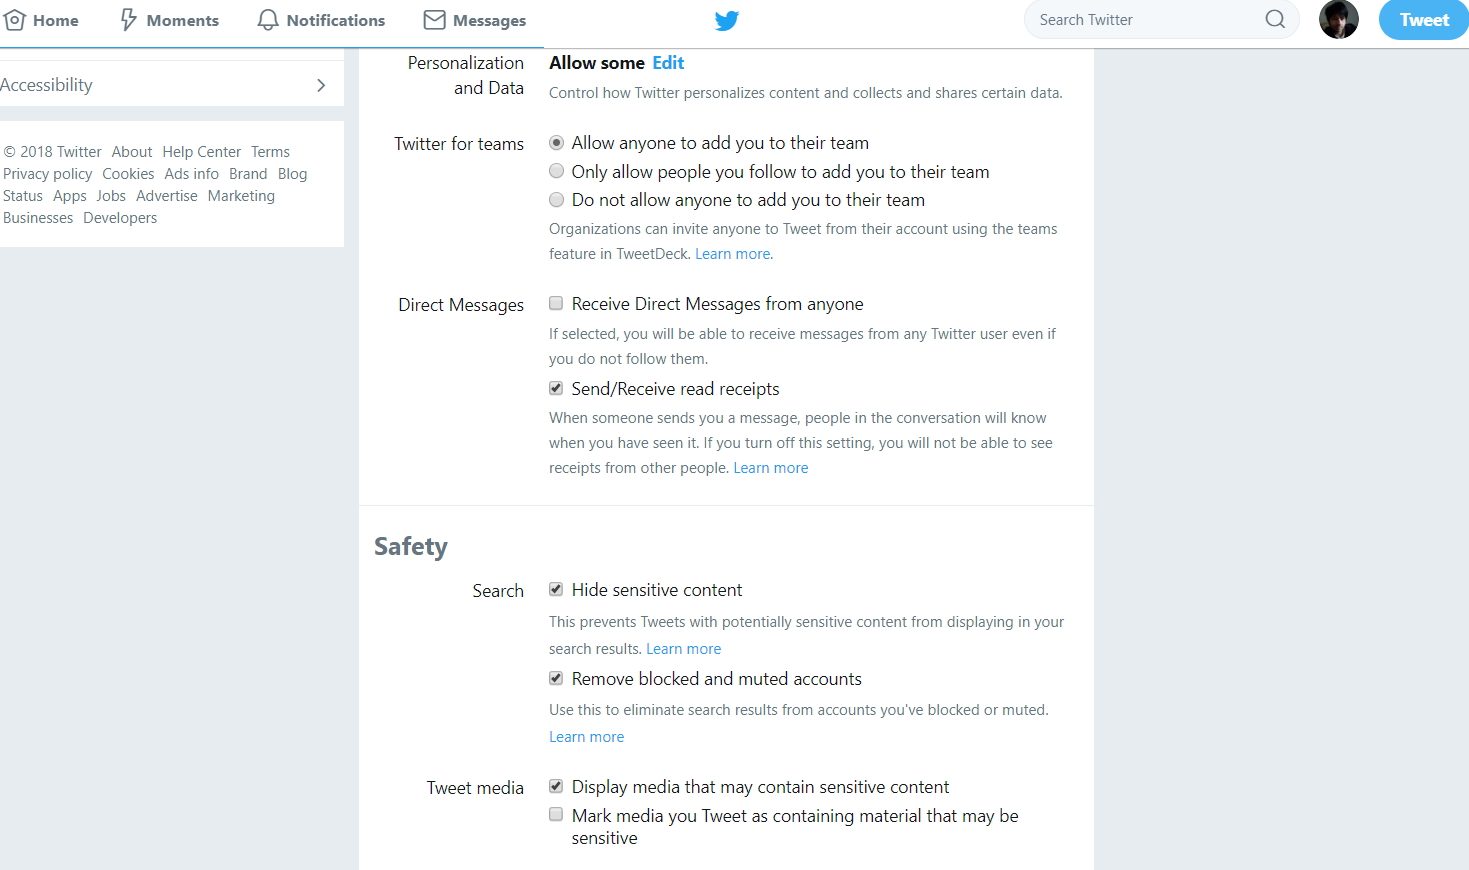

In [2]:
from IPython.display import Image
Image(filename='twitter_Sensitivitysettings.png')

## Dataset

We have used a real-time archive of twitter data. This is a simple collection of JSON formatted twitter data grabbed from the general twitter stream, that has been archived by the twitterstream team of 'archive.org', for the purposes of research, history, testing and memory. This is the "Spritzer" version, the most light and shallow of Twitter grabs. 
We chose this data set, as it is not processed by its curator and has been scraped from the Twitter API. 

The link from where we downloaded the JSON is:
https://archive.org/details/archiveteam-twitter-stream-2017-11#reviews

A sample line of json from this dataset is:
Sample line:


    {"created_at":"Fri Apr 04 05:29:35 +0000 2014","id":451954715140448256,"id_str":"451954715140448256","text":"Parachutisten piloot rampvliegtuig wilde stunt uithalen: BRUSSEL - De crash van een Pilatus Porter PC... http:\/\/t.co\/CHyop0olJF #airnews","source":"\u003ca href=\"http:\/\/twitterfeed.com\" rel=\"nofollow\"\u003etwitterfeed\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":261656971,"id_str":"261656971","name":"News from the sky","screen_name": "NewsFromTheSky","location":"\u2708", "url":"http:\/\/newsfromsky.blogspot.com\/","description":"The largest multilingual collection of real-time aviation news.","protected":false,"followers_count":4872,"friends_count":119,"listed_count":161,"created_at":"Sun Mar 06 12:04:48 +00002011","favourites_count":0,"utc_offset":3600,"time_zone":"Casablanca","geo_enabled":false,"verified":false,"statuses_count":225843,"lang":"en","contributors_enabled":false,"is_translator":false,"is_translation_enabled":false,"profile_background_color":"C0DEED","profile_background_image_url":"http:\/\/pbs.twimg.com\/profile_background_images\/213834908\/twitter_long.png","profile_background_image_url_https":"https:\/\/pbs.twimg.com\/profile_background_images\/213834908\/twitter_long.png","profile_background_tile":false,"profile_image_url":"http:\/\/pbs.twimg.com\/profile_images\/1263821148\/tw_image_normal.png","profile_image_url_https":"https:\/\/pbs.twimg.com\/profile_images\/1263821148\/tw_image_normal.png","profile_banner_url":"https:\/\/pbs.twimg.com\/profile_banners\/261656971\/1363878621","profile_link_color":"0084B4","profile_sidebar_border_color":"C0DEED","profile_sidebar_fill_color":"DDEEF6","profile_text_color":"333333","profile_use_background_image":false,"default_profile":false,"default_profile_image":false,"following":null,"follow_request_sent":null,"notifications":null},"geo":null,"coordinates":null,"place":null,"contributors":null,"retweet_count":0,"favorite_count":0,"entities":{"hashtags":[{"text":"airnews","indices":[128,136]}],"symbols":[],"urls":[{"url":"http:\/\/t.co\/CHyop0olJF","expanded_url":"http:\/\/bit.ly\/1sfnNKj","display_url":"bit.ly\/1sfnNKj","indices":[105,127]}],"user_mentions":[]},"favorited":false,"retweeted":false,"possibly_sensitive":false,"filter_level":"medium","lang":"nl"}



Note: We originally planned to use a Twitter dataset containing same fields, that was released for the Cloud Computing 
course project. But because the server was shut down in the middle, we did not have access to this dataset anymore. Hence,
searched for this dataset and proceeded with it.

## Pipeline
The pipeline of our project is as mentioned below:


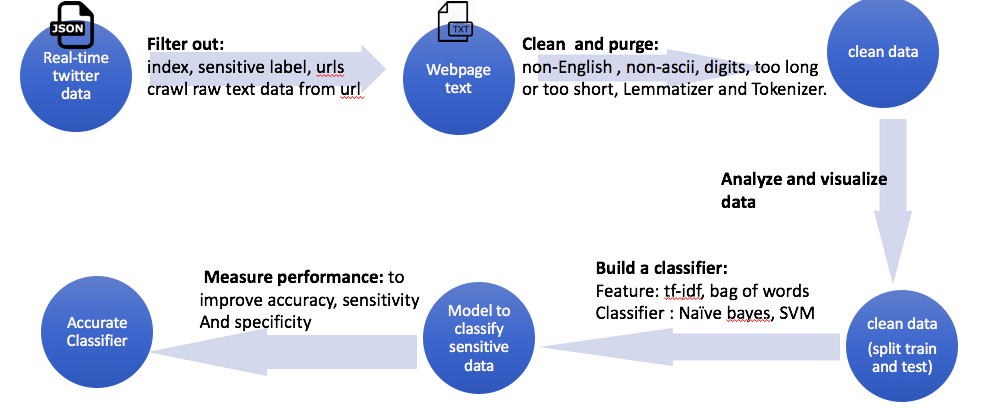

In [3]:
Image(filename='pl.png')

## Importing the libraries

a list of pakages should be imported :)

In [2]:
import json
import csv
import glob
import numpy as np
import re
import urllib
from bs4 import BeautifulSoup
from textblob import TextBlob
import pandas as pd
import ast
import pickle
from matplotlib import pyplot as plt
import string
import re
import os
import collections
from collections import Counter
import scipy.optimize
import scipy.sparse as sp
import random
import nltk
from nltk.classify import SklearnClassifier
import sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC, LinearSVC
from IPython.display import Image

## Preprocessing

### 1. Filtering out URLs and Labels

The raw data contains plenty of information/attributes as discussed above. However, in this project, we are mainly interested in context contained in `urls`. So the first step is to filter out the key information `id_str`, `possibly_sensitive`, `urls`. (If a tweet does not have `possibly_sensitive` or `urls`, we just ignored it.)

In [ ]:
def raw_to_url(fnames, sname):
    id_to_url = open(sname, 'w')
    csvwriter = csv.writer(id_to_url)
    csvwriter.writerow(["id_str",  "possibly_sensitive", "urls"])
    i = 0
    for fname in fnames:
        with open(fname, 'r') as f:
            for line in f:
                line = json.loads(line)
                if "entities" not in line:
                    continue
                if "possibly_sensitive" not in line:
                    continue
                if "urls" in line["entities"] and len(line["entities"]["urls"]) > 0:
                    dic = {}
                    dic["id_str"] = line["id_str"]
                    dic["possibly_sensitive"] = line["possibly_sensitive"]
                    dic["urls"] = line["entities"]["urls"]
                    if dic["possibly_sensitive"]:
                        i += 1
                    csvwriter.writerow(dic.values())
    id_to_url.close()
    
# run code under the folder of date
files = glob.glob("*/*.json")
raw_to_url(files, "id_sensitive_url.csv")

this is a head sample of the urls and labels we filtered out:


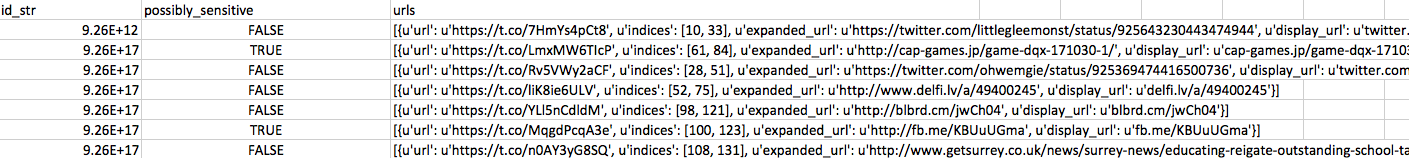

In [3]:
Image(filename='csv.png')

### 2. Scraping webpage content from URLs:

We use `urllib`, a package that collects several modules for working with URLs, and together with BeautifulSoup, to extract meaningful text from the webpage.

In [ ]:
def url_to_text(url):
    print(url)
    try:
        html = urllib.request.urlopen(url)
    except Exception as e:
        return
    soup = BeautifulSoup(html)
    # kill all script and style elements
    for script in soup(["script", "style"]):
        script.extract()    # rip it out
    # get text
    text = soup.get_text()
    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = ' '.join(chunk for chunk in chunks if chunk)
    return text

def url_parse(url_dict):
    url_dict = ast.literal_eval(url_dict)
    url = url_dict[0]['expanded_url']
    return url


def create_rawtext(csvPath='./id_sensitive_url.csv', label=False):
    cnt = 0
    df = pd.read_csv(csvPath)
    textname = str(label)+ '_rawtext.txt'
    for index, row in df.iterrows():
        if cnt > 4000:
            return
        print(index)
        if index <= 25100:
            continue
        if row['possibly_sensitive'] == label:
            id_str = str(row['id_str'])
            url = url_parse(row['urls'])
            text = url_to_text(url)
            if text == None:
                continue
            b = TextBlob(text)
            try:
                if b.detect_language() != 'en':
                    continue
            except Exception as e:
                continue
            cnt += 1
            with open(textname, 'a') as the_file:
                the_file.write(id_str + ' '+ text +'\n')

create_rawtext('id_sensitive_url.csv', True)
create_rawtext('id_sensitive_url.csv', False)

In the raw data, we found that the data is very dirty, with multi languages, strange charactors which can't be encoded in unicode. So we impelemented clean data processing to get good data that an be fed to a model.

     ''DMMGAMES アダルトPCゲーム 動画 月額動画 見放題ch ライト 10円動画 無料動画''
     ''стоимость согласования перепланировки помещений Открыть навигацию''
     ''T163ï½¥85(C)ï½¥57ï½¥86 18:00ï½�2:00 æ—©è‹—ã€�ã‚¹ãƒ¬ãƒ³ãƒ€ãƒ¼æ¸…æ¥šå¦»ã€‘(39æ­³)''
     ''موضة جمال ستايل بيت مطبخ تكنولوجيا فنون ''

### 3. clean data
The way we did cleaning is by
taking each webpage raw text, get rid of non-English, non-ascii, digits, and converted evry word to lower case, then lemmatized and tokenized it. 

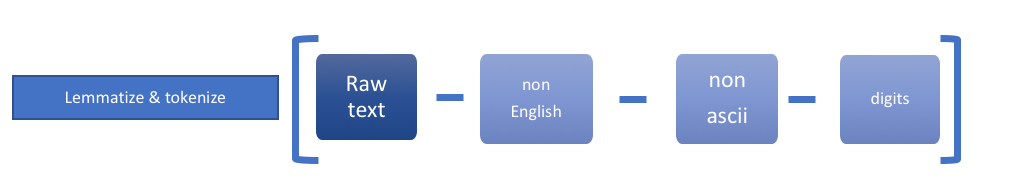

In [4]:
Image(filename='clean.png')

In [ ]:
def clean_textdata(file_raw, file_clean):
    cnt = 0
    true_tokens_page = []
    f = open(file_raw, 'r')
    for line in f:
        print(cnt)
        cnt += 1
        try:
            id_str, text = line.split(" ", 1)
            text = text.encode('ascii',errors='ignore').decode() # get rid of non ascii char
            text = text.lower()
            remove_digits = str.maketrans('', '', digits) # get rid of digits
            text = text.translate(remove_digits)
            tokenizer = RegexpTokenizer(r'\w+')
            tokens = tokenizer.tokenize(text) # tokenize
            wnl = nltk.WordNetLemmatizer()
            tokens = [wnl.lemmatize(t) for t in tokens]
            tokens = [w for w in tokens if not w in stopwords.words('english') and 3<=len(w)<= 30 ]
            true_tokens_page.append(tokens)
        except Exception as e:
            continue
    print(len(true_tokens_page))
    with open(file_clean, 'wb') as fp:
        pickle.dump(true_tokens_page, fp)

clean_textdata('True_rawtext.txt', 'True_cleantext')
clean_textdata('False_rawtext.txt', 'False_cleantext')

Showed as above, the clean data are stored in `True_rawtext.txt` and `False_rawtext.txt`.

## Content Analysis and Visualization

###  1. sentiment analysis

The purpose of doing subjective and polarity is that we want to see if sensitive and non-sensitive webpages will have different sentiment trends. To analyze theses information, we utilized `sentiment_assessments` method in package `textblob`. In details, `polarity` is a float within the range [-1.0, 1.0] where -1.0 is very negative and 1.0 is very positive. `subjectivity` is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [2]:
def sentiment_analysis(fname, newfname):
    sentiment_file = open(newfname, 'w')
    csvwriter = csv.writer(sentiment_file)
    csvwriter.writerow(["polarity", "subjectivity", "assessments"])

    with open(fname, "rb") as tf:
        lines = pickle.load(tf)
    for word_list in lines:
        line = " ".join(word_list)
        b = TextBlob(line)
        res = b.sentiment_assessments
        res = list(res)
        dic = {}
        dic["polarity"] = res[0]
        dic["subjectivity"] = res[1]
        dic["assessments"] = res[2]
        csvwriter.writerow(dic.values())
    sentiment_file.close()

# store the sentiment values in csv files
sentiment_analysis("True_cleantext", "true_sentiment_clean.csv")
sentiment_analysis("False_cleantext", "false_sentiment_clean.csv")

#### Visualization of sentiment results

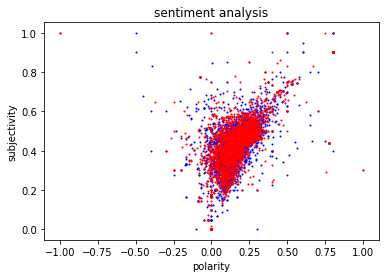

the median polarity value for sensitive text is 0.14453196740128557


<Figure size 432x288 with 0 Axes>

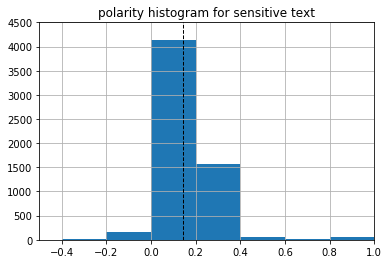

the median polarity value for non-sensitive text is 0.14915447542653426


<Figure size 432x288 with 0 Axes>

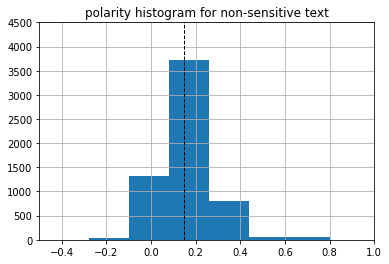

<Figure size 432x288 with 0 Axes>

In [3]:
df_true = pd.read_csv("true_sentiment_clean.csv")
df_false = pd.read_csv("false_sentiment_clean.csv")
df_true = df_true.head(n=6000)
df_false = df_false.head(n=6000)
plt.title("sentiment analysis")
plt.scatter(df_false['polarity'],df_false['subjectivity'],color='blue',s=1, label='non-sensitive')
plt.scatter(df_true['polarity'],df_true['subjectivity'],color='red', s=1, label='sensitive')

plt.xlabel("polarity")
plt.ylabel("subjectivity")
plt.show()
#plt.savefig("senti_cluster.png")
plt.clf()


df_true.hist(column='polarity')
plt.xlim(-0.5,1)
plt.ylim(0,4500)
plt.title("polarity histogram for sensitive text")
print("the median polarity value for sensitive text is {}".\
      format(df_true['polarity'].median()))
plt.axvline(df_true['polarity'].median(), color='k', linestyle='dashed', linewidth=1)
#plt.savefig("pol_hist_true.png")
plt.show()
plt.clf()


df_false.hist(column='polarity')
plt.xlim(-0.5,1)
plt.ylim(0,4500)
plt.title("polarity histogram for non-sensitive text")
print("the median polarity value for non-sensitive text is {}".\
      format(df_false['polarity'].median()))
plt.axvline(df_false['polarity'].median(), color='k', linestyle='dashed', linewidth=1)
#plt.savefig("pol_hist_false.png")
plt.show()
plt.clf()

### 2. topic analysis

[Topic models](https://en.wikipedia.org/wiki/Topic_model) can be used to discover the latent semantic structures of an extensive text body. Using topic modelling, we can find out topics involved in an article. With the help of topic analysis, we can explore the topics in both sensitive webpages and non-sensitive webpages. 

[LDA (Latent Dirichlet allocation)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation#Topics) is a representative generative statistical model to find the hidden topics. In LDA, each document is assumed to consist of multiple topics, and each topic is a probability distribution of different words that would occur. In this project, we used `LatentDirichletAllocation` from `sklearn` to find out the topics.

In [4]:
stop_words = nltk.corpus.stopwords.words('english')
top_k_words = 10

def display_topics(model, feature_names, top_k_words):
    op = pd.DataFrame()
    for topic_idx, topic in enumerate(model.components_):
        features = [feature_names[i]
                        for i in topic.argsort()[:-top_k_words-1:-1]]
        op['Topic '+str(topic_idx)] = features
    return op


def find_topics(fname, typename):
    corpus = []
    with open(fname, "rb") as tf:
        lines = pickle.load(tf)
    for word_list in lines:
        line = " ".join(word_list)
        corpus.append(line)
    tf_vectorize = sklearn.feature_extraction.text.CountVectorizer(stop_words='english', min_df=0.01, max_df=0.5)
    tf_documents = tf_vectorize.fit_transform(corpus)
    lda = LatentDirichletAllocation(n_components=10, learning_method='online')
    lda.fit(tf_documents)
    outp = display_topics(lda, tf_vectorize.get_feature_names(), top_k_words)
    print("top 10 words for each topic in " + typename + " text")
    print(outp.head(n=10))

find_topics("True_cleantext", "sensitive")
print("######################################")
find_topics("False_cleantext","non-sensitive")

top 10 words for each topic in sensitive text
    Topic 0    Topic 1   Topic 2    Topic 3   Topic 4       Topic 5   Topic 6  \
0      view       news      sale      reply       sex         photo       ago   
1  duration       year  bracelet  christmas      girl         email     month   
2   youtube      trump      gold       good      free           use  facebook   
3     watch       said      gift        ago      porn         start      http   
4     music      world      free      point   amateur       message   comment   
5      http    medical       buy      month       big  subscription       alt   
6    report   business     point      merry      live           day      post   
7     later     health     price       look      chat       private      open   
8  playlist  president     quick      think  download        access     image   
9      play   american     urban     really      anal       feature       img   

     Topic 7           Topic 8    Topic 9  
0      reply      

## Classification
To build a sensitive webpage classifier, first we need to genenrate featrures from text data, and choose a clasiifier to train.
We'd like to compare two features: 

       TF-IDF vs Bag of Words
and three classifier:

        Naive Bayes vs SVM vs Multilayer Peceptron
        

In [ ]:
########### load data and prepare labels ##############
with open ('True_cleantext', 'rb') as tf:
    true_text = pickle.load(tf)
with open ('False_cleantext', 'rb') as ff:
    false_text = pickle.load(ff)
########################################################

In [ ]:
def prepare_TFIDF():
    corpus = []
    for word_list in true_text:
        line = " ".join(word_list)
        corpus.append(line)


    for word_list in false_text:
        line = " ".join(word_list)
        corpus.append(line)

    tf_vectorize = sklearn.feature_extraction.text.TfidfVectorizer(max_features=5000)
    tf_documents = tf_vectorize.fit_transform(corpus)

    label = [1] * len(true_text) + [0] * len(false_text)
    tf_documents, label = shuffle(tf_documents, label)
    train_X = tf_documents[: 15000]
    train_y = label[: 15000]

    test_X = tf_documents[15000 :]
    test_y = label[15000 :]
    return train_X, train_y, test_X, test_y

def find_frequent_indicator_words(threshold, true, false):
    sensitive_words = set([word for tweet in true for word in tweet ])
    plain_words = set([word for tweet in false for word in tweet ])
    
    sens_diff_words = sensitive_words - (sensitive_words & plain_words)
    plain_diff_words = plain_words - (sensitive_words & plain_words)
    sens_word_counts = collections.Counter([word for tweet in true for word in tweet if word in sens_diff_words])
    plain_word_counts = collections.Counter([word for tweet in false for word in tweet if word in plain_diff_words])
    
    for word in sens_diff_words:
        if sens_word_counts[word] < threshold:
            sens_word_counts.pop(word)
    for word in plain_diff_words:
        if plain_word_counts[word] < threshold:
            plain_word_counts.pop(word)
    return dict(sens_word_counts), dict(plain_word_counts)

def prepare_BOW(most_common):
    true_false_data = [(text, 'pos') for text in true_text] + [(text, 'neg') for text in false_text]
    random.shuffle(true_false_data)

    all_words = nltk.FreqDist([word for tweet in true_text for word in tweet ] + [word for tweet in false_text for word in tweet ])
    most_common_word = [word for (word,_) in all_words.most_common(10000)]

    def make_feature(doc):
        doc_words = set(doc)
        feature = {}
        if most_common:
            for word in most_common_word:
                feature[word] = (word in doc_words)
            return features
        else:
            for word in sens_word_counts:
                feature[word] = (word in doc_words)
            for word in plain_word_counts:
                feature[word] = (word in doc_words)
            return feature

    train_set = nltk.apply_features(make_feature, true_false_data[:15000])
    test_set = nltk.apply_features(make_feature, true_false_data[15000:])
    return train_set, test_set

train_set, test_set = prepare_BOW(True)
# try 3 classifiers:
classifier = nltk.NaiveBayesClassifier.train(train_set)
print (nltk.classify.accuracy(classifier,test_set))
classifier.show_most_informative_features()

clf = LinearSVC()
classifier = SklearnClassifier(clf, sparse=False).train(train_set)
print (nltk.classify.accuracy(classifier,test_set))

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(500, 50), random_state=1)
classifier = SklearnClassifier(clf, sparse=False).train(train_set)
print (nltk.classify.accuracy(classifier,test_set))

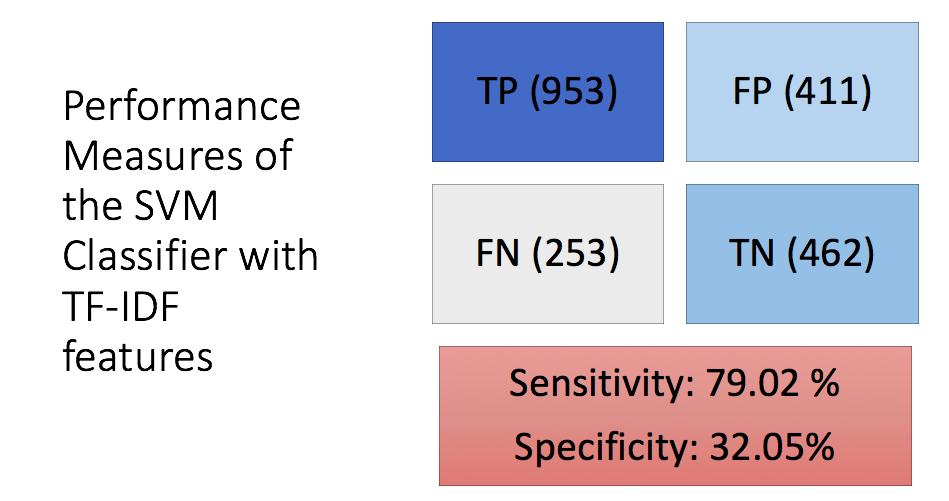

In [5]:
Image(filename='cm.png')

From this, we understand that our model performs better in identifying the portion of 'sensitive' tweets that are correctly classified as such than in identifying the portion of 'non-sensitive' tweets that are correctly classified as 'non-sensitive'.

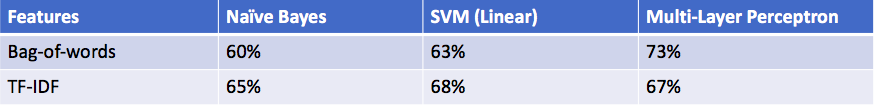

In [6]:
Image(filename='table.png')

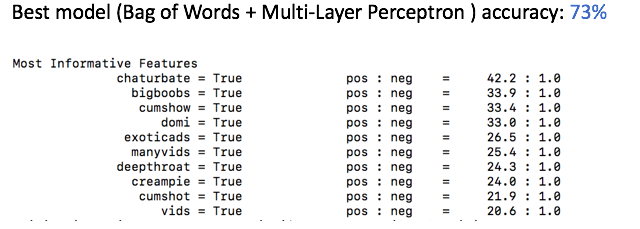

In [3]:
Image(filename='ct.png')

## Discussion and Future works

We were able to conclude the following from our research on this sample of data (15,000 training data and 5000 test data):

1. Using LDA, we were able to see that two main reasons for a tweet to be marked sensitive are if the url contains links to sites where 'pornography' or 'policially' sensitive words are replete.
2. Sensitive tweets are marginally, slightly more positive than non-sensitive tweets, as their polarity score is slightly higher than non-sensitive tweets.
3. With respect to models, Multi-Layer Perception with bag-of-words feature performed with the best accuracy (73%).

In future, 
we would like to increase the accuracy of this model by identifying and removing potential noise factors, applying dimensionality reduction on other fetaures such as user's location, followers_count, and user-specific details to understand correlations between user and tweets that are marked sensitive.

### Source and Related Work

To finish this project, we refer to some papaers and tech blogs for help.

[1] Ramos, Juan. "Using tf-idf to determine word relevance in document queries." Proceedings of the first instructional conference on machine learning. Vol. 242. 2003.

[2] https://buhrmann.github.io/tfidf-analysis.html

[3] https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a

[4] Blei, David M., Andrew Y. Ng, and Michael I. Jordan. "Latent dirichlet allocation." Journal of machine Learning research 3.Jan (2003): 993-1022.

[5] https://de.dariah.eu/tatom/topic_model_python.html